# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
#пипы
!pip install pandas -q
!pip install phik -q
!pip install matplotlib -q
!pip install scikit-learn==1.0.2 -q

In [2]:
import pandas as pd
import warnings
warnings.simplefilter("ignore") 
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
from scipy import stats as st
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from sklearn.model_selection import cross_val_score

In [3]:
#для начала загрузим данные из нашего датасета и сохраним в переменную
data = pd.read_csv('/datasets/autos.csv', sep=',')
display(data.head(10))
data.info()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В данных замечены пропуски, выведем отдельно их количество

In [4]:
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

В некоторых столбцах довольно много пропусков, поэтому удалить строчки с ними - будет сильной потерей для данных, а удалить полностью признак тоже нельзя, потому что он выглядит довольно значимым. <br/>
Принято решение удалить все строчки где есть пропуски в столбцах Gearbox и Model. А в остальных столбцах заменить все пропущенные значения на категорию - 'unknown'.

In [5]:
data = data.dropna(subset=(['Gearbox','Model']))
data[['VehicleType','FuelType','Repaired']] = data[['VehicleType','FuelType','Repaired']].fillna('unknown')

In [6]:
data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Теперь пропусков нет, можно двигаться дальше. Изменим в столбцах с датами тип данных на Datetime для более удобной работы с ними в дальнейшем, в некоторых столбцах формат включает в себя дату, в некоторых нет. Учтем это

In [7]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format = '%Y-%m-%d %H:%M:%S')
data['LastSeen'] = pd.to_datetime(data['LastSeen'], format = '%Y-%m-%d %H:%M:%S')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%dT')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318962 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        318962 non-null  datetime64[ns]
 1   Price              318962 non-null  int64         
 2   VehicleType        318962 non-null  object        
 3   RegistrationYear   318962 non-null  int64         
 4   Gearbox            318962 non-null  object        
 5   Power              318962 non-null  int64         
 6   Model              318962 non-null  object        
 7   Kilometer          318962 non-null  int64         
 8   RegistrationMonth  318962 non-null  int64         
 9   FuelType           318962 non-null  object        
 10  Brand              318962 non-null  object        
 11  Repaired           318962 non-null  object        
 12  DateCreated        318962 non-null  datetime64[ns]
 13  NumberOfPictures   318962 non-null  int64   

Теперь проверим данные на дубликаты.

In [8]:
data.duplicated().sum()

4

Обнаружено 4 явных дубликата, удалим их

In [9]:
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth', 'NumberOfPictures', 'PostalCode']


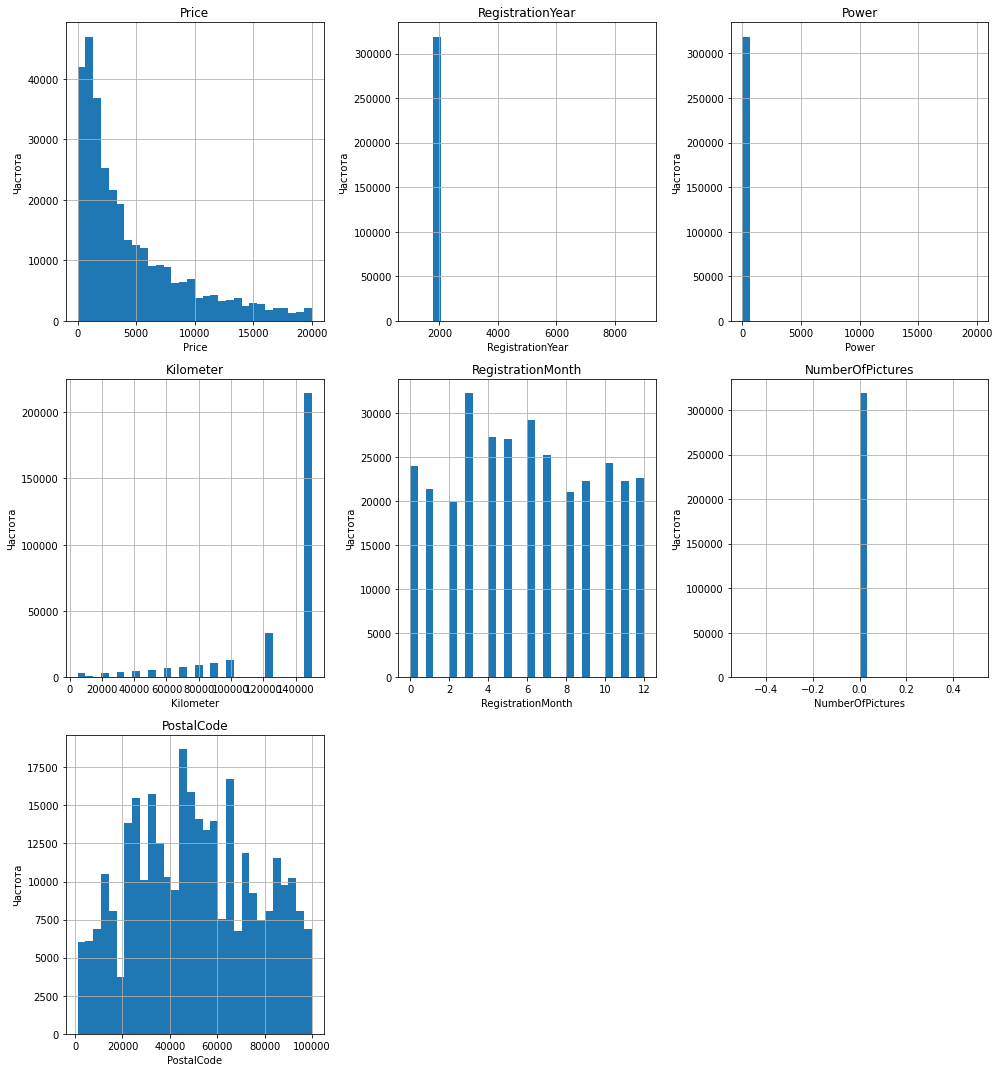

In [10]:
num_columns = data.select_dtypes(include=['float64','int64']).columns.tolist()
print(num_columns)
    
    #исключим столбец id из результатов
if 'id' in num_columns:
    num_columns.remove('id')
        
plt.figure(figsize=(14, 15))
for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
    plt.subplot(3, 3, i + 1)  # 3 строки, 3 столбца, текущий график
    
    # Строим гистограмму для текущего столбца
    data[column].hist(bins=30)
    
    # Добавляем заголовок с названием столбца
    plt.title(column)
    
    # Добавляем метки для осей
    plt.xlabel(column)
    plt.ylabel('Частота')
        
plt.tight_layout()
plt.show()

Явных дубликатов нет, проверим уникальные названия в каждой категории на опечатки

In [11]:
#отберем все категориальные столбцы 
cat_columns = data.select_dtypes(include=['object']).columns.tolist()
# Цикл for для вывода списков уникальных значений по каждому категориальному столбцу
for column in cat_columns:
    unique_values = data[column].unique()
    print(f"Уникальные значения для столбца '{column}': {unique_values}")
    print()

Уникальные значения для столбца 'VehicleType': ['unknown' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'coupe'
 'other']

Уникальные значения для столбца 'Gearbox': ['manual' 'auto']

Уникальные значения для столбца 'Model': ['golf' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe' 'passat'
 'navara' 'twingo' 'a_klasse' 'scirocco' '5er' 'meriva' 'arosa' 'c4'
 'civic' 'transporter' 'punto' 'e_klasse' 'clio' 'kadett' 'one' 'fortwo'
 '1er' 'b_klasse' 'signum' 'astra' 'a8' 'jetta' 'polo' 'fiesta' 'c_klasse'
 'micra' 'vito' 'sprinter' '156' 'escort' 'forester' 'xc_reihe' 'scenic'
 'a4' 'a1' 'combo' 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' 'corsa'
 '80' '147' 'z_reihe' 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos'
 'touran' 'getz' 'insignia' 'ka' 'almera' 'megane' 'a3' 'lupo' 'r19'
 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt' 'impreza' 'vectra' 'berlingo'
 'tiguan' 'i_reihe' 'sharan' '6_reihe' 'panda' 'up' 'seicento' 'ceed'
 'kangoo' '5_reihe' 'yeti' 'octavia' 'mii' 'rx_

Данные проверены, опечаток не найдено.

Проводя промежуточный подытог проделанной работы по подготовке данных можно сказать, что данные были загружены, проверены на соответствие содержания описанию файла, проверены типы данных в каждом столбце, где надо изменены на более подходящие. В категориальных столбцах данные были проверены на опечатки. Также была проверка на пропуски и дубликаты. Относительно малочисленные пропуски были удалены, а многочисленные заменены на неизвестную категорию 'unknown'. Дубликаты были найдены и удалены. 

## Анализ данных

Выведем информацию о данных и изучим возможные выбросы.

In [12]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,318958.000000,318958.000000,318958.000000,318958.000000,318958.000000,318958.0,318958.000000
mean,4608.905502,2003.427031,114.965265,128844.738179,5.908107,0.0,50766.394149
std,4564.241216,30.517461,185.627579,36620.680186,3.634281,0.0,25780.246706
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30455.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.000000
75%,6700.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71357.000000
max,20000.000000,9000.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Какие аномалии замечены:
* есть машины с ценой 0
* годы регистрации неадекватно большие и маленькие (1000 и 9000)
* существует 0 месяц регистрации
* во всем столбце с количеством фото на сайте стоит значение 0
* кое где почтовый код записан некорректно

Выведем диаграммы для более наглядного представления, а столбец с Количеством фото удалим как неинформативный. Также удалим столбец с почтовым индексом, так как это слишком индивидуальное значение, которое врятли будет иметь сильное влияние на цену.

In [13]:
data = data.drop('NumberOfPictures', axis=1)
data = data.drop('PostalCode', axis=1)

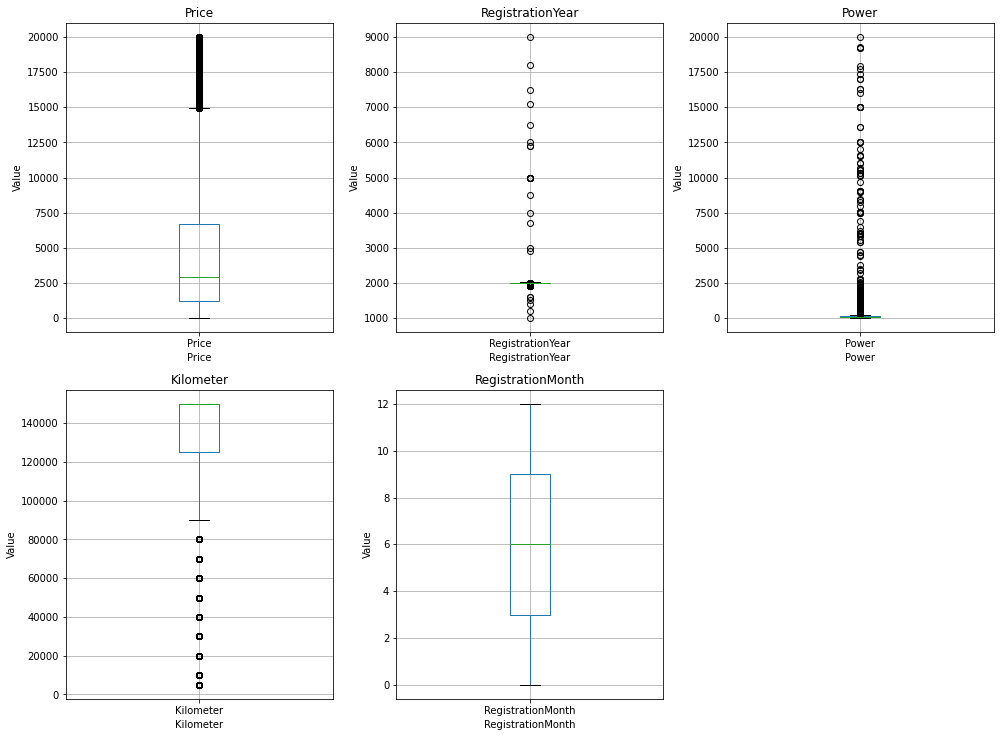

In [14]:
num_columns = data.select_dtypes(include=['float64','int64']).columns.tolist()
plt.figure(figsize=(14, 15))
for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
    plt.subplot(3, 3, i + 1)  # 2 строки, 3 столбца, текущий график
    
    # Строим график размаха для текущего столбца
    data.boxplot(column=column, ax=plt.gca())
    
    # Добавляем заголовок с названием столбца
    plt.title(column)
    
    # Добавляем метки для осей
    plt.xlabel(column)
    plt.ylabel('Value')
        
plt.tight_layout()
plt.show()

В данных замечено довольно много выбросов. Применим фильтры к столбцам

In [15]:
data = data.query('1 <= Price <= 9000')

In [16]:
data = data.query('1990 <= RegistrationYear <= 2014')

In [17]:
data = data.query('1 <= Power <= 230')

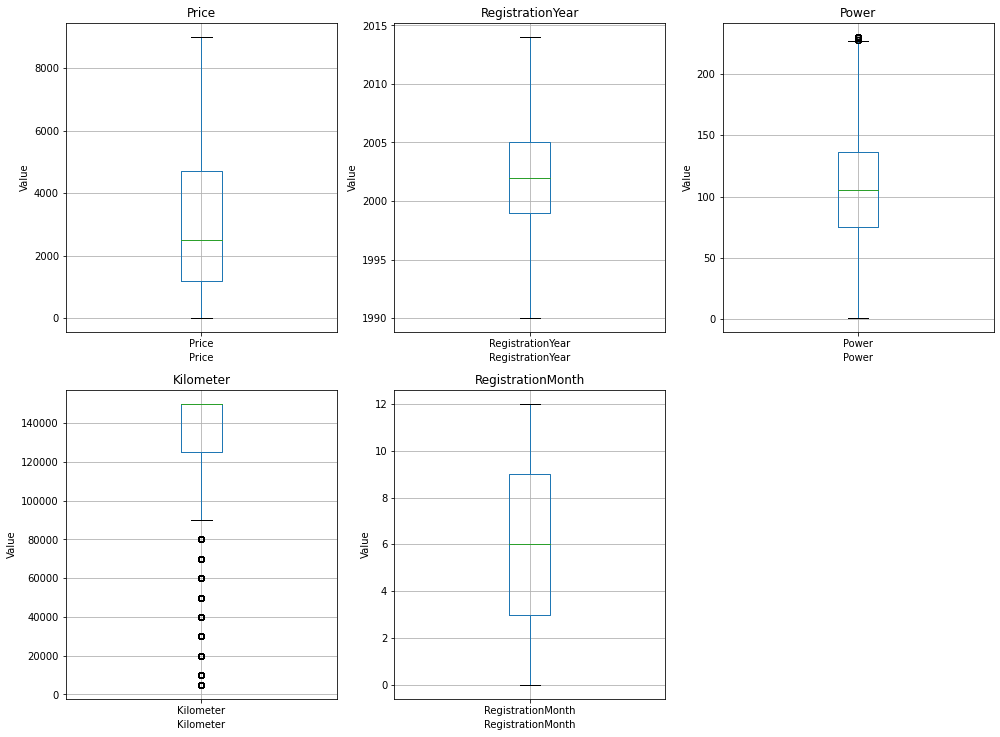

In [18]:
plt.figure(figsize=(14, 15))
for i, column in enumerate(num_columns):
    # Создаем subplot для текущего столбца
    plt.subplot(3, 3, i + 1)  # 2 строки, 3 столбца, текущий график
    
    # Строим график размаха для текущего столбца
    data.boxplot(column=column, ax=plt.gca())
    
    # Добавляем заголовок с названием столбца
    plt.title(column)
    
    # Добавляем метки для осей
    plt.xlabel(column)
    plt.ylabel('Value')
        
plt.tight_layout()
plt.show()

Теперь данные очищены от аномальных значений и выбросов, удалены неинформативные столбцы. Но мы не можем утверждать точно про остальные столбцы, насколько они связаны с целевым признаком. Выведем матрицу корреляции чтобы увидеть все связи.

In [19]:
#для вывода матрицы корреляции подготовим датафрейм без столбцов с типом данных datetime
#дата скачивания анкеты из базы, дата ее создания и дата последней активности пользователя врятли повлияют на цену машины значительно,
#поэтому принято решение удалить эти признаки совсем
data = data.drop('DateCrawled', axis=1)
data = data.drop('LastSeen', axis=1)
data = data.drop('DateCreated', axis=1)

In [20]:
#соберем все численные переменные в датафрейме с помощью функции и сохраним их в переменную
num_columns = data.select_dtypes(include=['float64','int64']).columns.tolist()
interval_cols = ['Kilometer', 'RegistrationMonth', 'RegistrationYear']
num_columns = [col for col in num_columns if col not in interval_cols]

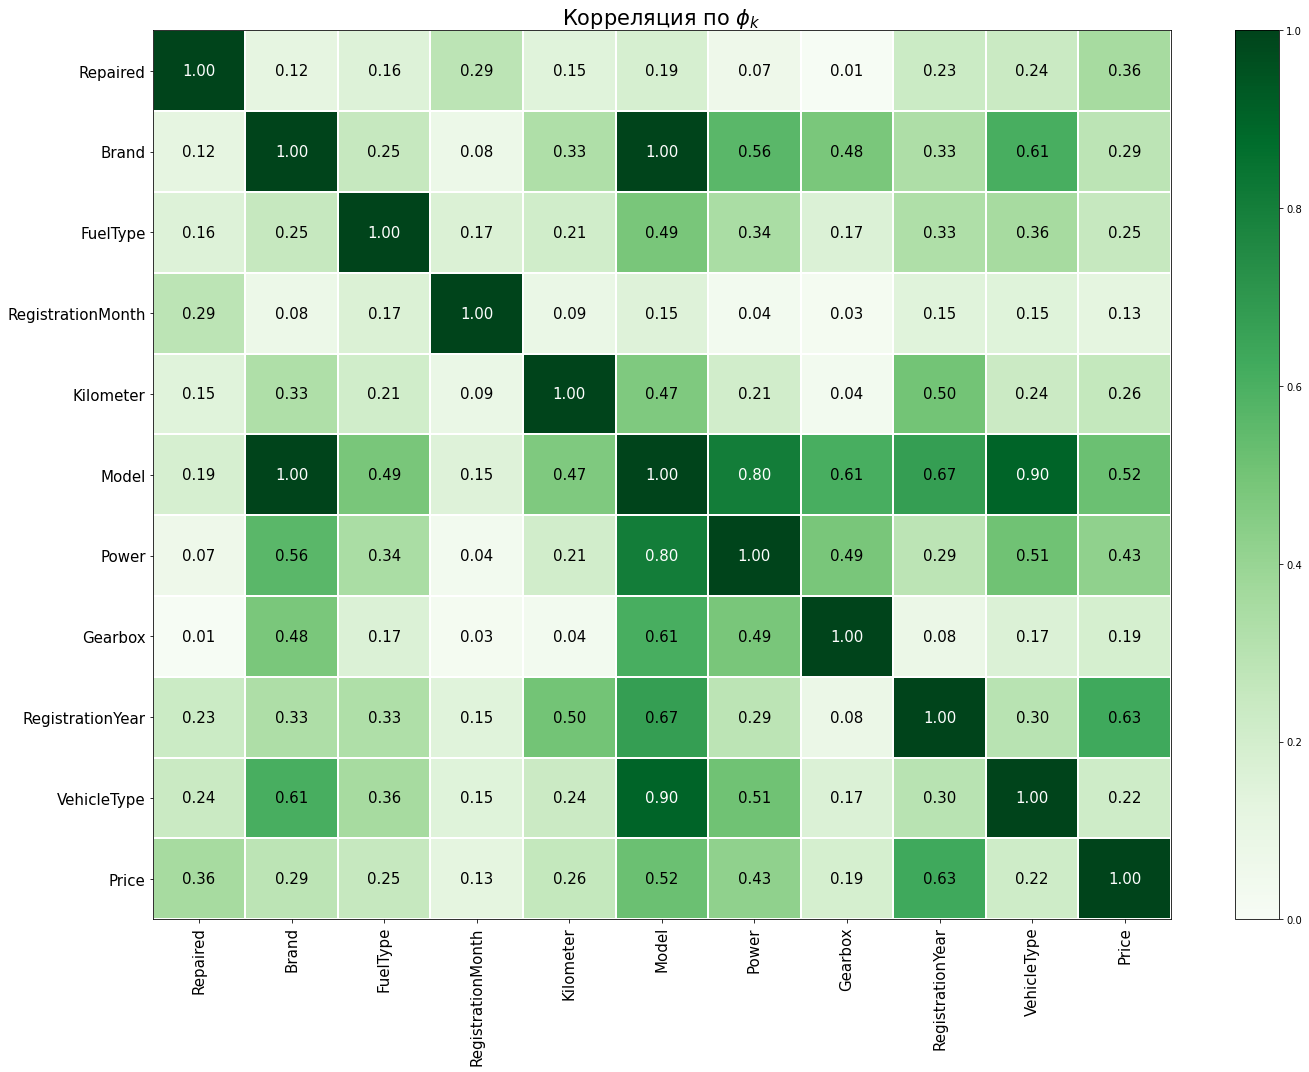

In [21]:
phik_matrix = data.phik_matrix(interval_cols=num_columns)

#строим матрицу корреляции Phik
plot_correlation_matrix(phik_matrix.values, 
                       x_labels = phik_matrix.columns,
                       y_labels = phik_matrix.index,
                       vmin = 0, vmax = 1,color_map = 'Greens',
                       title = r'Корреляция по $\phi_k$',
                       fontsize_factor = 1.5, 
                       figsize = (20,15)
                       )

Теперь можно выделить признаки, которые больше всего влияют на целевой признак - Цену автомобиля:
* Год регистрации
* Модель
* Мощность 
* Была ли машина в ремонте
* Пробег

Также влияние оказывает марка автомобиля, но у этого признака очень сильная корреляция с моделью автомобиля - 1. <br/>
Наименьшее влияние на целевой признак оказал столбец с месяцем регистрации автомобиля. Звучит логично, учитывая что в нем данные встречаются про 13 месяцев. Он тем более не сможет быть информативным. Удалим его.

In [22]:
data = data.drop('RegistrationMonth', axis=1)

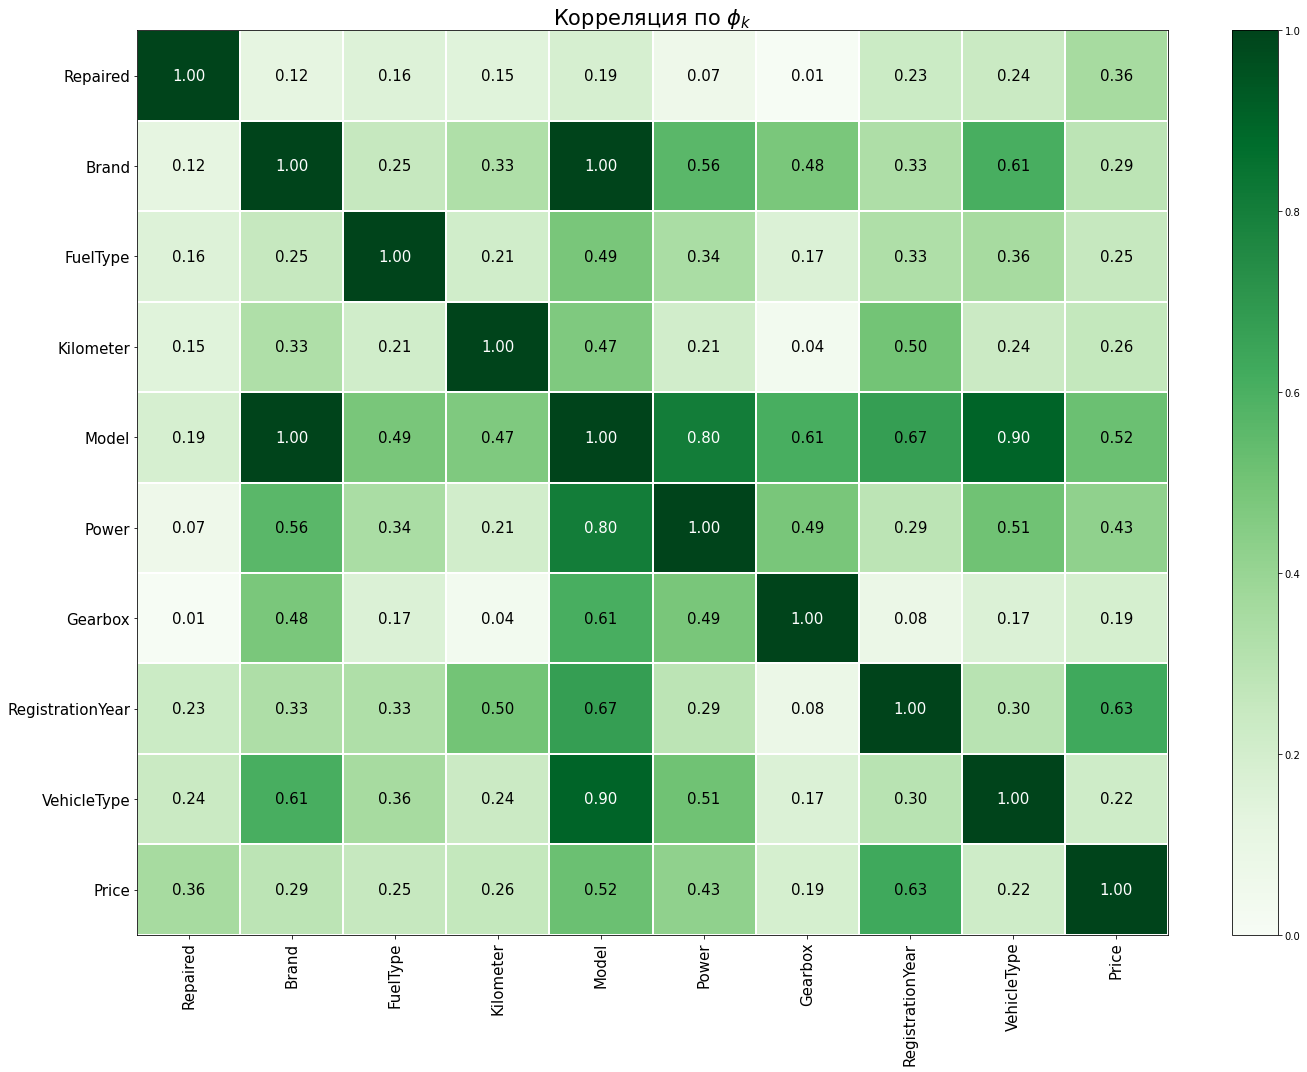

In [23]:
phik_matrix = data.phik_matrix(interval_cols=num_columns)

#строим матрицу корреляции Phik
plot_correlation_matrix(phik_matrix.values, 
                       x_labels = phik_matrix.columns,
                       y_labels = phik_matrix.index,
                       vmin = 0, vmax = 1,color_map = 'Greens',
                       title = r'Корреляция по $\phi_k$',
                       fontsize_factor = 1.5, 
                       figsize = (20,15)
                       )

После всех проделанных удалений лучше еще раз проверить данные на наличие дубликатов

In [24]:
data.duplicated().sum()

32267

Найдено довольно много дубликатов. При обучении модели они будут бесполезны, поэтому удалим их

In [25]:
data = data.drop_duplicates().reset_index(drop=True)

In [26]:
data.duplicated().sum()

0

Теперь данные отлично подготовлены для дальнейшей работы с ними и обучения моделей предсказания. В них были устранены аномалии и выбросы, также были удалены неинформативные столбцы, в которых содержались данные не относящиеся к предсказанию целевой переменной, либо же те столбцы, где были обнаружены сильные аномалии при выгрузке.

## Обучение моделей

In [27]:
#для начала разделим наш датасет на тренировочную и тестовую выборки
RANDOM_STATE = 42
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    data.drop('Price', 
        axis=1
    ),
    data['Price'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE)


In [28]:
#для удобства выведем списки всех численных переменных, созданные ранее с помощью функции
num_columns = X_train.select_dtypes(include=['float64','int64']).columns.tolist()
num_columns

['RegistrationYear', 'Power', 'Kilometer']

In [29]:
cat_columns = X_train.select_dtypes(include=['object']).columns.tolist()
for column in cat_columns:
        unique_values = X_train[column].unique()
        print(f"Уникальные значения для столбца '{column}': {unique_values}")

Уникальные значения для столбца 'VehicleType': ['bus' 'small' 'wagon' 'other' 'sedan' 'unknown' 'coupe' 'suv'
 'convertible']
Уникальные значения для столбца 'Gearbox': ['manual' 'auto']
Уникальные значения для столбца 'Model': ['touran' '2_reihe' 'ka' 'megane' 'focus' 'other' '3er' 'golf' 'caddy'
 'a3' 'combo' 'galaxy' 'kalos' 'fox' '4_reihe' 'almera' 'a_klasse'
 'toledo' 'clio' 'bora' 'corsa' 'primera' 'a6' 'v70' 'scenic' 'yaris'
 'punto' 'fortwo' 'twingo' '1_reihe' 'fiesta' 'bravo' 'c3' 'transporter'
 'fabia' 'grand' '5er' 'carisma' 'mondeo' 'c_klasse' 'a2' 'alhambra' '156'
 '147' 'kangoo' 'vectra' 'passat' 'accord' '500' 'santa' '3_reihe' 'omega'
 'zafira' '159' 'vito' 'sportage' 'b_klasse' 'arosa' 'scirocco' 'ducato'
 '850' 'one' 'transit' 'escort' 'polo' 'slk' 'e_klasse' 'voyager' 'modus'
 'a4' 'laguna' 'z_reihe' 'getz' 'berlingo' 'rio' 'astra' 'sorento' 'panda'
 'aveo' 'beetle' 'espace' 'leon' 'mx_reihe' 'c1' 'octavia' 'civic' 'lupo'
 'up' 'ibiza' 'rx_reihe' 'i_reihe' 'corolla' 

### Пайплайн для моделей линейной регрессии и дерева регрессии

In [93]:
# cоздаём пайплайн для подготовки признаков из списка cat_columns:
ohe_pipe = Pipeline([
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (    'ohe', 
            OneHotEncoder(sparse=False, handle_unknown='ignore',drop='first')
        )
])

In [94]:
# создайте общий пайплайн для объединения шагов подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, cat_columns),
        ('num', MinMaxScaler(), num_columns)   
    ], 
    remainder =  'passthrough'
)
print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('simpleImputer_ohe',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['VehicleType', 'Gearbox', 'Model', 'FuelType',
                                  'Brand', 'Repaired']),
                                ('num', MinMaxScaler(),
                                 ['RegistrationYear', 'Power', 'Kilometer'])])


In [95]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [96]:
param_distributions = [
    {
    # словарь для модели DecisionTreeRegressor()
    'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': range(1,6),
    'models__min_samples_split': range(2,8),
    'models__min_samples_leaf': range(2, 8),
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [97]:
# Определим метрику RMSE
rmse_scorer = make_scorer(mean_squared_error, squared=False)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [98]:
%%time
randomized_search.fit(X_train, y_train)

CPU times: user 58.4 s, sys: 17.4 s, total: 1min 15s
Wall time: 1min 15s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=Fals

In [99]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired']),
                        

In [37]:
# посчитаем метрику RMSE при кросс валидации
#roc_auc_cv = cross_val_score(randomized_search, X_train, y_train, scoring = rmse_scorer).mean()

In [38]:
#print(f"RMSE при кросс валидации: {randomized_search.best_score_}")

In [80]:
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 1847.2947123712142


### Пайплайн для модели CatBoost


In [40]:
# Создание модели
model = CatBoostRegressor(random_state=RANDOM_STATE, loss_function="RMSE", iterations=80, verbose=0)

# Создание пайплайна
pipe = Pipeline(steps=[
    ('classifier', model)
])

# Параметры для RandomizedSearchCV
param_distributions = {
    'classifier__iterations': range(50, 200),
    'classifier__depth': [4, 6, 8, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Определение метрики
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Создание RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipe,
    param_distributions,
    cv=5,
    scoring=rmse_scorer,
    n_iter=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [41]:
%%time
# Обучение модели с подбором гиперпараметров
random_search.fit(X_train, y_train, classifier__cat_features=cat_columns)

CPU times: user 4min 35s, sys: 1.17 s, total: 4min 36s
Wall time: 4min 57s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier',
                                              <catboost.core.CatBoostRegressor object at 0x7ff388ab5f70>)]),
                   n_jobs=-1,
                   param_distributions={'classifier__depth': [4, 6, 8, 10],
                                        'classifier__iterations': range(50, 200),
                                        'classifier__learning_rate': [0.01,
                                                                      0.05, 0.1,
                                                                      0.2]},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, squared=False))

In [73]:
# Вывод лучших гиперпараметров
best_params = random_search.best_params_
print(f"Лучшие гиперпараметры: {best_params}")

Лучшие гиперпараметры: {'classifier__learning_rate': 0.01, 'classifier__iterations': 115, 'classifier__depth': 6}


In [43]:
# Кросс-валидация на лучшей модели
#train_pool = Pool(X_train, y_train, cat_features=cat_columns)

# Кросс-валидация на лучшей модели
#cv_resultsTRUE = cross_val_score(best_model, X_train, y_train, scoring=rmse_scorer, cv=5, fit_params={'cat_features': cat_columns}).mean()
#print(f"RMSE при кросс-валидации: {cv_resultsTRUE}")

In [74]:
print ('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 1481.741088241773


### Обучение модели LightGBM

In [45]:
# Создание трансформера для предобработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_columns),
        ('cat', OneHotEncoder(sparse=False, handle_unknown='ignore',drop='first'), cat_columns)
    ])

# Создание модели
model = lgb.LGBMRegressor(random_state=RANDOM_STATE, objective='regression', metric='rmse', verbosity=-1)

# Создание пайплайна
pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# Параметры для RandomizedSearchCV
param_distributions = {
    'classifier__n_estimators': range(50, 200),
    'classifier__num_leaves': [31, 50, 70],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [-1, 4, 6, 8, 10]
}

# Определение метрики
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Создание RandomizedSearchCV
random_search2 = RandomizedSearchCV(
    pipe,
    param_distributions,
    cv=5,
    scoring=rmse_scorer,
    n_iter=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [46]:
%%time
# Обучение модели с подбором гиперпараметров
random_search2.fit(X_train, y_train)

CPU times: user 4min 56s, sys: 17.8 s, total: 5min 14s
Wall time: 5min 14s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['RegistrationYear',
                                                                                'Power',
                                                                                'Kilometer']),
                                                                              ('cat',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse=False),
                           

In [47]:
print('Лучшая модель и её параметры:\n\n', random_search2.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Kilometer']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'Repaired'])])),
                ('classifier',
                 LGBMRegressor(learning_rate=0.01, max_depth=4, metric='rmse',
                               n_estimators=55, num_leaves=50,
            

In [48]:
print ('Метрика лучшей модели на тренировочной выборке:', random_search2.best_score_)

Метрика лучшей модели на тренировочной выборке: 1804.2608094781249


In [49]:
# Кросс-валидация на лучшей модели
#rmse_cv = cross_val_score(random_search2.best_estimator_, X_train, y_train, scoring=rmse_scorer, cv=5).mean()
#print(f"RMSE при кросс-валидации: {rmse_cv}")

## Анализ моделей
Были получены время обучения моделей, время предсказания и показатели метрики RMSE на валидационной выборке. Из них учитывая требоания заказчика нам предстоит выбрать лучшую и проверить ее работу на тестовой выборке. <br/>
Для начала выведем время обучения, предсказания и метрики для всех лучших моделей полученных выше

In [100]:
best_model1 = randomized_search.best_estimator_.named_steps['models']
best_model2 = f"CatBoostRegressor('{best_params}')'"
best_model3 = random_search2.best_estimator_.named_steps['classifier']


#scores = [roc_auc_cv,cv_resultsTRUE,rmse_cv]
name_of_best_models = [best_model1,best_model2,best_model3]
models = [randomized_search, random_search, random_search2 ]

fit_times = []
score_times = []
rmse_scores = []

# Обучение моделей и извлечение времени выполнения
for model in models:
    cv_results1 = pd.DataFrame(model.cv_results_)
    best_index = cv_results1['mean_test_score'].idxmin()
    fit_times.append(cv_results1.loc[best_index, 'mean_fit_time'])
    score_times.append(cv_results1.loc[best_index, 'mean_score_time'])
    rmse_scores.append(model.best_score_)

# Печать результатов
for i, (fit_time, score_time,rmse_scores) in enumerate(zip(fit_times, score_times,rmse_scores), start=1):
    print(f"Показатели модели {name_of_best_models[i-1]}")
    print(f"Время обучения лучшей модели: {fit_time} секунд")
    print(f"Время предсказания лучшей модели : {score_time} секунд")
    print(f"Значение метрики RMSE на валидационной выборке модели  : {rmse_scores}")
    print()


Показатели модели DecisionTreeRegressor(max_depth=1, min_samples_leaf=6, random_state=42)
Время обучения лучшей модели: 1.6089393615722656 секунд
Время предсказания лучшей модели : 0.15572595596313477 секунд
Значение метрики RMSE на валидационной выборке модели  : 1847.2947123712142

Показатели модели CatBoostRegressor('{'classifier__learning_rate': 0.01, 'classifier__iterations': 115, 'classifier__depth': 6}')'
Время обучения лучшей модели: 6.782056140899658 секунд
Время предсказания лучшей модели : 0.04033064842224121 секунд
Значение метрики RMSE на валидационной выборке модели  : 1481.741088241773

Показатели модели LGBMRegressor(learning_rate=0.01, max_depth=4, metric='rmse', n_estimators=55,
              num_leaves=50, objective='regression', random_state=42,
              verbosity=-1)
Время обучения лучшей модели: 8.482510375976563 секунд
Время предсказания лучшей модели : 0.6766763210296631 секунд
Значение метрики RMSE на валидационной выборке модели  : 1804.2608094781249



Результаты получены и выведены выше. Учитывая те критерии, которые важны заказчику, а именно:
* качество предсказания;
* время обучения модели;
* время предсказания модели.

Исходя из них можно сделать вывод, что лучшей моделью их всех 3 получается модель CatBoostRegressor с гиперпараметрами (iterations = 115, learning_rate = 0.01, depth = 6, loss_function = 'RMSE', verbose = 0). Ее показатели в метрике RMSE и времени в сумме лучше чем у остальных моделей, я считаю что она лучше всего подойдет для задачи заказчика. 


Теперь сохраним отдельно лучшую модель и проверим ее работу на тестовой выборке

In [101]:
# Предсказание на тестовой выборке
y_pred = random_search.predict(X_test)

In [102]:
# Вычисление метрики RMSE на тестовой выборке
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Значение метрики RMSE на тестовой выборке : {rmse}")

Значение метрики RMSE на тестовой выборке : 1490.170808677776


Проверка сделана, метрика действительно показывает довольно хорошие результаты. Задача решена.

## **Вывод для заказчика**: <br/>
Лучшее качество предсказаний дает модель **CatBoostRegressor с гиперпараметрами (iterations = 115, learning_rate = 0.01, depth = 6, loss_function = 'RMSE', verbose = 0)**. Ее показатель метрики RMSE на тестовой выборке равен 1490.74, она обошла другие модели по показателю метрики на валидационной выборке, а время ее обучения заняло 6.88 секунды.<br/><br/>
Лучшее время обучения показывает модель **DecisionTreeRegressor c гиперпараметрами (max_depth=1, min_samples_leaf=6, min_samples_split=3, random_state=RANDOM_STATE)**. Ее время обучения составляет 2 мин 14 секунд, но показатель метрики - 1847.4, что хуже чем у первой модели.<br/>
На время предсказания опираться бессмысленно, так как у всех моделей оно занимает миллисекунды, но даже если учитывать их, в данном случае CatBoostRegressor справляется за 0.0382s против 0.195s у DecisionTreeRegressor. <br/><br/>

**Итого:** для решения задачи заказчика лучше всего подходит модель CatBoostRegressor с гиперпараметрами (iterations = 115, learning_rate = 0.01, depth = 6, loss_function = 'RMSE', verbose = 0), я советую в дальнейшем использовать ее.
